
Tabla de conteo real de idiomas (cada idioma contado individualmente) por tipo de institución:
idioma            aleman  frances  hebreo  italiano
tipo_institucion                                   
Privado               17      185      88         5
Público                1        6       1         0


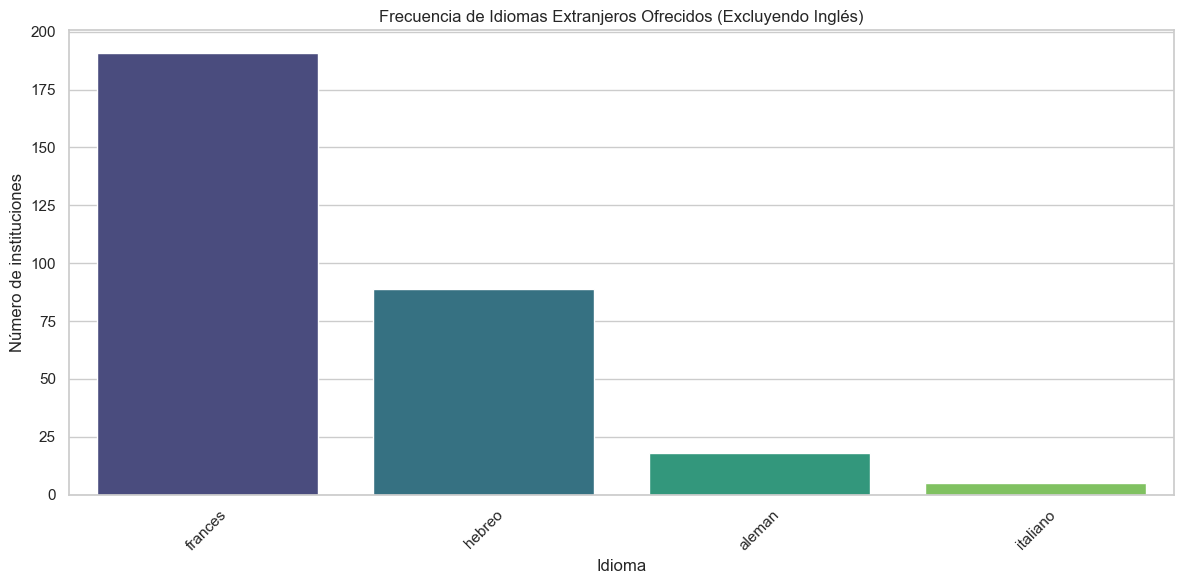

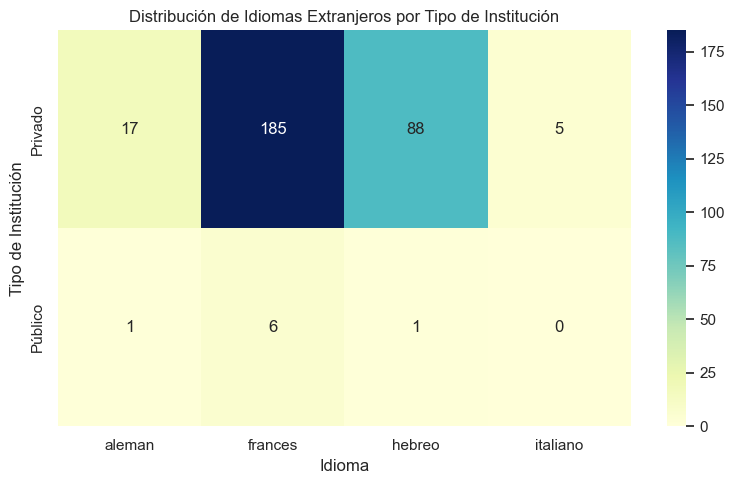

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

# 1. Cargar archivo limpio
df = pd.read_csv('../data/limpio/establecimientos_educativos_limpio.csv')

# 2. Crear columna 'ofrece_idioma_extranjero' (excluyendo inglés)
def ofrece_idioma_extranjero(idiomas):
    if not isinstance(idiomas, str):
        return 0
    idiomas_lista = [i.strip().lower() for i in idiomas.split(',')]
    idiomas_validos = [i for i in idiomas_lista if i not in ['', '-', 'nan', 'ninguno']]
    return int(any(i not in ['ingles', 'inglés'] for i in idiomas_validos))

df['ofrece_idioma_extranjero'] = df['idiomas'].apply(ofrece_idioma_extranjero)

# 3. Clasificar prestador_de_servicio como público (0) o privado (1)
prestadores_publicos = {'OFICIAL', 'CONCESION', 'EDUCACION MISIONAL CONTRATADA', 'REGIMEN ESPECIAL'}

def clasificar_privado(prestador):
    if isinstance(prestador, str):
        if prestador.strip().upper() in prestadores_publicos:
            return 0
    return 1

df['privado'] = df['prestador_de_servicio'].apply(clasificar_privado)

# 4. Filtrar columnas para modelar
df_model = df[['privado', 'ofrece_idioma_extranjero']].dropna().copy()


# 5. Conteo real de idiomas por tipo de institución
idioma_registros = []

for _, fila in df.iterrows():
    if not isinstance(fila['idiomas'], str):
        continue
    idiomas_lista = [i.strip().lower() for i in fila['idiomas'].split(',')]
    idiomas_validos = [i for i in idiomas_lista if i not in ['', '-', 'nan', 'ninguno', 'ingles', 'inglés']]
    for idioma in idiomas_validos:
        idioma_registros.append({
            'tipo_institucion': 'Público' if fila['privado'] == 0 else 'Privado',
            'idioma': idioma
        })

df_idiomas = pd.DataFrame(idioma_registros)

tabla_idiomas = pd.crosstab(df_idiomas['tipo_institucion'], df_idiomas['idioma'])

print("\nTabla de conteo real de idiomas (cada idioma contado individualmente) por tipo de institución:")
print(tabla_idiomas)

# 6. Conteo total de idiomas ofrecidos (excluyendo inglés)
conteo_idiomas = df_idiomas['idioma'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=conteo_idiomas.index, 
            y=conteo_idiomas.values, 
            hue=conteo_idiomas.index,
            palette="viridis", 
            legend=False)
plt.title('Frecuencia de Idiomas Extranjeros Ofrecidos (Excluyendo Inglés)')
plt.ylabel('Número de instituciones')
plt.xlabel('Idioma')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. mapa de calor de distribución de idiomas por tipo de institución
plt.figure(figsize=(8,5))
sns.heatmap(tabla_idiomas, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribución de Idiomas Extranjeros por Tipo de Institución')
plt.ylabel('Tipo de Institución')
plt.xlabel('Idioma')
plt.tight_layout()
plt.show()

# 8. Top 10 municipios con más idiomas extranjeros diferentes al inglés

# Asegurar que no hay NaNs en 'nombremunicipio'
df['nombremunicipio'] = df['nombremunicipio'].fillna('Desconocido')

# Crear un dataframe de idiomas por municipio
idiomas_municipio = []

for _, fila in df.iterrows():
    if not isinstance(fila['idiomas'], str):
        continue
    idiomas_lista = [i.strip().lower() for i in fila['idiomas'].split(',')]
    idiomas_validos = [i for i in idiomas_lista if i not in ['', '-', 'nan', 'ninguno', 'ingles', 'inglés']]
    for idioma in idiomas_validos:
        idiomas_municipio.append({
            'municipio': fila['nombremunicipio'],
            'idioma': idioma
        })

df_idiomas_municipio = pd.DataFrame(idiomas_municipio)

# Contar cuántos idiomas distintos se ofrecen en cada municipio
conteo_municipios = df_idiomas_municipio.groupby('municipio')['idioma'].nunique()

# Seleccionar top 10 municipios
top10_municipios = conteo_municipios.sort_values(ascending=False).head(10).reset_index()

# Graficar
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_municipios,
    x='municipio',
    y='idioma',
    palette=sns.color_palette("viridis", n_colors=10),
    hue='municipio',
    dodge=False,
    legend=False
)

plt.title('Top 10 Municipios con Mayor Diversidad de Idiomas Extranjeros (Excluyendo Inglés)')
plt.ylabel('Número de Idiomas Distintos')
plt.xlabel('Municipio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()